# ArtGraph Dataset: Exploratory Data Analysis
In this notebook EDA is performed on the content of ArtGraph. This analysis is not related to the visual captioning task, but to the part of the system that will perform classification over the classes and labels of the artworks in the graph.

In [58]:
import sys
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats
import numpy as np

In [15]:
PROJECT_DIR = Path(os.getcwd()).resolve().parent
SRC_DIR = PROJECT_DIR / "src"
DATA_DIR = PROJECT_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"

In [78]:
CATEGORICAL_FEATURES = ("artist", "style", "genre")
MULTILABEL_FEATURES = ("tags", "media")

In [16]:
df = pd.read_csv(RAW_DATA_DIR / "artgraph_dataset.csv")
df

,image,artist,style,genre,tags,media
0,antonio-lopez_dead-girl-1957.jpg,antonio-lopez,surrealism,genre painting,NaN,NaN
1,antonio-lopez_artists-working.jpg,antonio-lopez,contemporary realism,genre painting,Standing,NaN
2,antonio-lopez_sinforoso-and-josefa-1955.jpg,antonio-lopez,realism,portrait,Cheek,NaN
3,anatoli-papian_portrait-of-anna-1983.jpg,anatoli-papian,expressionism,portrait,"Head, Cheek, Lady","oil, canvas"
4,hans-richter_portrait-of-dora-rukser-1927.jpg,hans-richter,cubism,portrait,Head,NaN
...,...,...,...,...,...,...
116470,alexander-ivanov_portrait-of-vittoria-marini.jpg,alexander-ivanov,romanticism,portrait,"female-portraits, Cheek","oil, canvas"
116471,alexander-ivanov_olive-trees.jpg,alexander-ivanov,romanticism,landscape,"Plant, forests-and-trees, Tree, Woody plant, B...","oil, canvas"
116472,alexander-ivanov_annunciation-1824.jpg,alexander-ivanov,academicism,religious painting,"Christianity, Virgin-Mary, Prophet, angels-and...",NaN
116473,alexander-ivanov_on-the-shore-of-the-bay-of-na...,alexander-ivanov,romanticism,landscape,"Mythology, islands-and-bays","oil, canvas"


In [17]:
df.describe()

,image,artist,style,genre,tags,media
count,116475,116475,116475,116475,95588,44849
unique,116475,2501,32,18,48524,927
top,antonio-lopez_dead-girl-1957.jpg,vincent-van-gogh,impressionism,portrait,Lady,"oil, canvas"
freq,1,1886,14799,20736,2081,22518


In [18]:
df.describe()

,image,artist,style,genre,tags,media
count,116475,116475,116475,116475,95588,44849
unique,116475,2501,32,18,48524,927
top,antonio-lopez_dead-girl-1957.jpg,vincent-van-gogh,impressionism,portrait,Lady,"oil, canvas"
freq,1,1886,14799,20736,2081,22518


Each artwork is assigned to a single artist, style, and genre. Not all artworks are assigned to tags and media. Also, an artwork can be associated to multiple tags and media.

In [19]:
def plot_column(df, column):
    # count the number of occurrences of each category
    value_counts = df[column].value_counts()

    print(f"In total there are {len(value_counts)} {column}s")

    # plot the distribution using a bar plot
    value_counts.plot(kind='barh')

    # set plot title and axis labels
    plt.title(f"Distribution of {column}s")
    plt.xlabel('Count')
    plt.ylabel('Value')

    # display the plot
    plt.show()

In total there are 18 genres


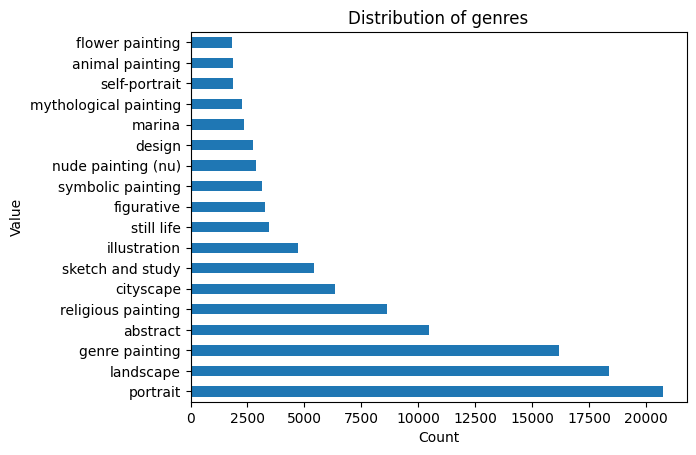

In [20]:
plot_column(df, "genre")

In total there are 32 styles


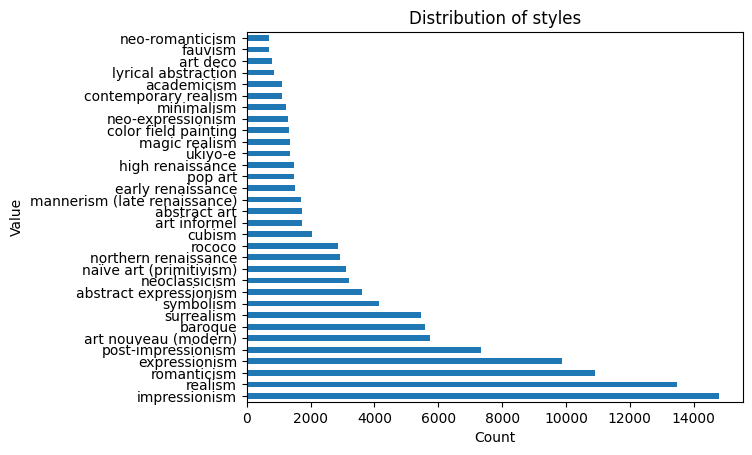

In [21]:
plot_column(df, "style")

In [22]:
artists_df = df.groupby(["artist"]).count()
artists_df = artists_df.reset_index()

In [23]:
print(f"There are {len(artists_df.loc[artists_df['image'] == 1])} artists with a single artwork")

There are 69 artists with a single artwork


In [24]:
print(f"There are {len(artists_df[artists_df['image'] >= 100])} artists with 100 or more artworks")

There are 242 artists with 100 or more artworks


<Axes: title={'center': 'Distribution of artists with most artworks'}, xlabel='Count', ylabel='Value'>

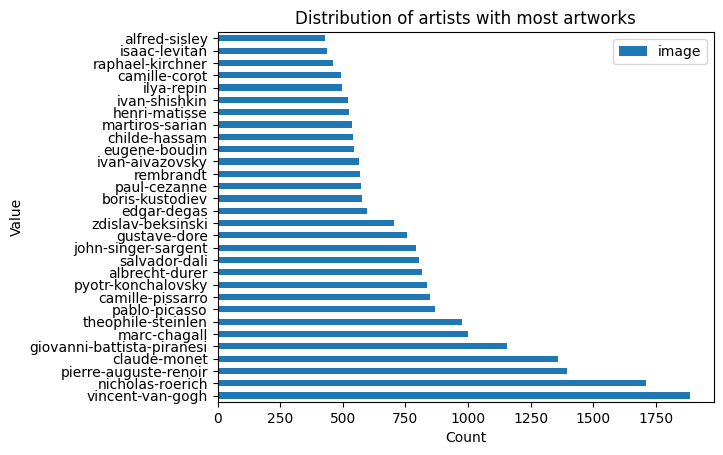

In [25]:
artists_with_most_works = artists_df.nlargest(30, "image")
artists_with_most_works.plot.barh(x="artist", y="image", xlabel="Count", ylabel="Value", title="Distribution of artists with most artworks")

In [34]:
def plot_multilabel_column(df, column):
    # count the number of occurrences of each category
    labels = df[column].tolist()
    labels = [label for label in labels if type(label) == str]
    labels_all = []
    for label in labels:
        labels_all.extend(label.split(", "))
    
    freq = Counter(labels_all)
    sorted_freqs = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    best_sorted_freqs = [freq for freq in sorted_freqs if freq[1] >= 100]
    print(f"There are {len(best_sorted_freqs)} {column} with 100 or more artworks associated")

    # create a bar plot of the frequencies
    plt.barh(range(len(best_sorted_freqs[:30])), [val[1] for val in best_sorted_freqs[:30]], align='center')
    plt.yticks(range(len(best_sorted_freqs[:30])), [val[0] for val in best_sorted_freqs[:30]])
    plt.xlabel('Count')
    plt.ylabel('Value')
    plt.title(f'Distribution of most common {column}')
    plt.show()

There are 429 tags with 100 or more artworks associated


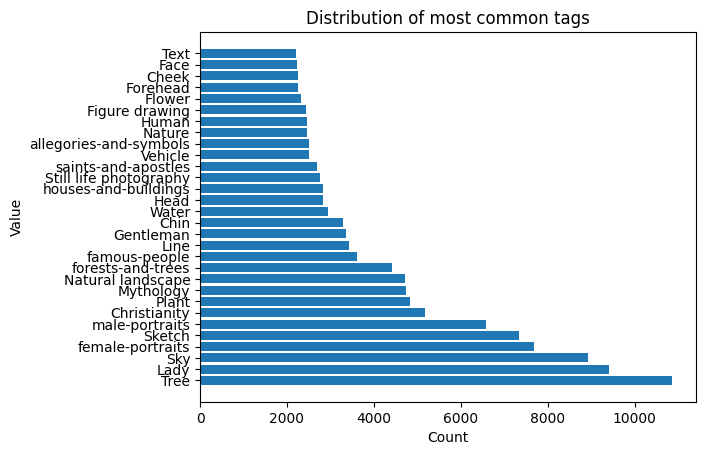

In [35]:
plot_multilabel_column(df, "tags")

There are 31 media with 100 or more artworks associated


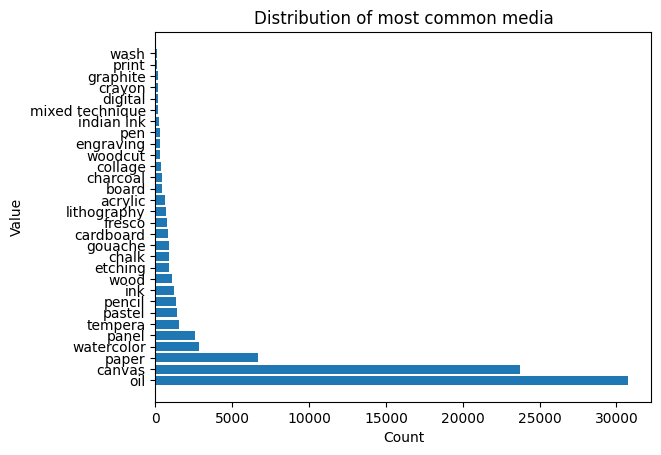

In [36]:
plot_multilabel_column(df, "media")

In [76]:
def lambda_coefficient(df, col1, col2):
    df = df.copy()

    # Convert categorical columns to numeric codes
    df[f'{col1}_code'] = df[col1].astype('category').cat.codes
    df[f'{col2}_code'] = df[col2].astype('category').cat.codes

    # Create a contingency table
    contingency_table = np.array(pd.crosstab(df[f'{col1}_code'], df[f'{col2}_code']))

    total = np.sum(contingency_table)

    e1_row = total - np.max(np.sum(contingency_table, axis=1)) # lambda(col2|col1)
    e1_col = total - np.max(np.sum(contingency_table, axis=0)) # lambda(col1|col2)

    e2_row = total - np.sum(np.max(contingency_table, axis=0))
    e2_col = total - np.sum(np.max(contingency_table, axis=1))

    lambda_col1_col2 = (e1_row - e2_row) / e1_row
    lambda_col2_col1 = (e1_col - e2_col) / e1_col

    print(f"lambda({col1}|{col2})={lambda_col1_col2}")
    print(f"lambda({col2}|{col1})={lambda_col2_col1}")

In [82]:
for feat1 in CATEGORICAL_FEATURES:
    for feat2 in CATEGORICAL_FEATURES:
        if feat1 < feat2:
            lambda_coefficient(df, feat1, feat2)
            print("\n")

lambda(artist|style)=0.10123135728560333
lambda(style|artist)=0.8173610291514222


lambda(artist|genre)=0.03664400596915934
lambda(genre|artist)=0.48822319013150334


lambda(genre|style)=0.23748942437251278
lambda(style|genre)=0.14149848538494827




The $\lambda$ score computed between the pairs of categorical features shows that we can reduce the errors in predicting the style and genre by 81% and 49% respectively, if we already know the artist who created the work.